In [1]:
from pathlib import Path

import ipywidgets as widgets
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.core.display import display
from statsmodels import api as sm

import rp2
from rp2 import data, hagai_2018, notebooks, paths, regression, ui
from evolution import Load_data, Linear_regression

import warnings

_ = notebooks.initialise_environment(
    "Mean_Var_Linear_Regression",
    dependencies=["Burst_Model_Fitting","Get_Responsive_Gene_Subset"],
)

In [2]:
def map_between_columns(df, index_column, value_column, indices):
    if isinstance(indices, list):
        indices = pd.Series(indices)
    df = df[[index_column, value_column]].drop_duplicates().dropna()
    df = df.loc[df[index_column].isin(indices)]
    index_map = df.set_index(index_column).squeeze()
    return indices.map(index_map).values


def map_gene_ids_to_mouse(species, ids):
    species_column = f"{species}_gene"
    return map_between_columns(all_orthologues, species_column, "mouse_gene", ids)


def make_condition_info_df(species):
    stats_columns = ["min", "max", "mean", "variance", "skew"]

    txburst_df = data.load_txburst_results(species, condition_columns, count_type)[index_columns + ["k_on", "k_off", "k_syn", "keep"]]
    txburst_df.rename(columns={"keep": "k_keep"}, inplace=True)

    info_df = condition_info_df.loc[condition_info_df.species == species, index_columns + stats_columns]
    info_df.rename(columns={col: f"rna_{col}" for col in stats_columns}, inplace=True)

    stats_df = info_df.merge(
        txburst_df,
        on=index_columns,
        how="left",
    )
    stats_df = stats_df.merge(
        condition_info_df[index_columns + ["bs_point", "bf_point"]],
        on=index_columns,
        how="left",
    )
    stats_df.rename(columns={"bs_point": "bs", "bf_point": "bf"}, inplace=True)
    stats_df.insert(1, "symbol", gene_info_df.loc[stats_df.gene].symbol.values)

    if species != "mouse":
        stats_df["mouse_id"] = map_gene_ids_to_mouse(species, stats_df.gene)
        stats_df["mouse_symbol"] = gene_info_df.loc[stats_df.mouse_id].symbol.values

    return stats_df


def make_condition_info_for_good_fits_df(species):
    stats_columns = ["min", "max", "mean", "variance", "skew"]

    txburst_df = data.load_txburst_results(species, condition_columns, count_type)[index_columns + ["k_on", "k_off", "k_syn", "keep"]]
    txburst_df.rename(columns={"keep": "k_keep"}, inplace=True)

    info_df = good_fit_condition_info_df.loc[good_fit_condition_info_df.species == species, index_columns + stats_columns]
    info_df.rename(columns={col: f"rna_{col}" for col in stats_columns}, inplace=True)

    stats_df = info_df.merge(
        txburst_df,
        on=index_columns,
        how="left",
    )
    stats_df = stats_df.merge(
        good_fit_condition_info_df[index_columns + ["bs_point", "bf_point"]],
        on=index_columns,
        how="left",
    )
    stats_df.rename(columns={"bs_point": "bs", "bf_point": "bf"}, inplace=True)
    stats_df.insert(1, "symbol", gene_info_df.loc[stats_df.gene].symbol.values)

    if species != "mouse":
        stats_df["mouse_id"] = map_gene_ids_to_mouse(species, stats_df.gene)
        stats_df["mouse_symbol"] = gene_info_df.loc[stats_df.mouse_id].symbol.values

    return stats_df


def make_mv_trend_info_df(species):
    species_gene_ids = analysis_orthologues[species].tolist()
    trend_info = mv_lr_df.loc[mv_lr_df.index.isin(species_gene_ids)].copy()
    trend_info.insert(0, "symbol", gene_info_df.loc[trend_info.index].symbol.values)

    if species != "mouse":
        trend_info["mouse_id"] = map_gene_ids_to_mouse(species, trend_info.index)
        trend_info["mouse_symbol"] = gene_info_df.loc[trend_info.mouse_id].symbol.values

    return trend_info


def make_mv_trend_info_for_good_fits_df(species):
    species_gene_ids = analysis_orthologues[species].tolist()
    trend_info = mv_lr_df_final.loc[mv_lr_df_final.index.isin(species_gene_ids)].copy()
    trend_info.insert(0, "symbol", gene_info_df.loc[trend_info.index].symbol.values)

    if species != "mouse":
        trend_info["mouse_id"] = map_gene_ids_to_mouse(species, trend_info.index)
        trend_info["mouse_symbol"] = gene_info_df.loc[trend_info.mouse_id].symbol.values

    return trend_info


def save_all_species_data(output_folder):
    rp2.create_folder(output_folder)
    for species in species_to_compare:
        make_condition_info_df(species).to_csv(output_folder.joinpath(f"{species}_condition_info_responsive_subset.csv"), index=False)
        make_condition_info_for_good_fits_df(species).to_csv(output_folder.joinpath(f"{species}_condition_info_responsive_good_fit_subset.csv"), index=False)
        
        trend_info_df = make_mv_trend_info_df(species)
        trend_info_df.to_csv(output_folder.joinpath(f"{species}_trend_info_responsive_subset.csv"))
        trend_info_good_fits_df = make_mv_trend_info_for_good_fits_df(species)
        trend_info_good_fits_df.to_csv(output_folder.joinpath(f"{species}_trend_info_responsive_good_fit_subset.csv"))

In [3]:
species_to_compare = ["mouse", "pig", "rabbit", "rat"]
use_responsive_gene_subset = True
results_output_path = "Output/Mean_var/"

In [4]:
lps_responsive_mouse_genes = hagai_2018.load_lps_responsive_genes()
all_orthologues = rp2.load_mouse_orthologues()
analysis_orthologues = rp2.load_one_to_one_mouse_orthologues().loc[lps_responsive_mouse_genes].reset_index()
analysis_orthologues.columns = analysis_orthologues.columns.str.slice(0, -5)

print(f"{len(analysis_orthologues):,} one-to-one arthologues")
print(analysis_orthologues.columns)
   
if use_responsive_gene_subset:
    responsive_genes = Load_data.load_responsive_analysis_genes()
    analysis_orthologues = analysis_orthologues.loc[responsive_genes.loc[analysis_orthologues.mouse].responsive_in_all.to_numpy()]
    print(f"  Using subset of {len(analysis_orthologues):,} genes that are responsive in all species.")

2,336 one-to-one arthologues
Index(['mouse', 'pig', 'rabbit', 'rat'], dtype='object')
  Using subset of 218 genes that are responsive in all species.


In [5]:
gene_info_df = pd.concat([rp2.load_biomart_gene_symbols_df(species) for species in species_to_compare])

In [6]:
condition_columns = ["replicate", "treatment", "time_point"]
index_columns = ["gene"] + condition_columns
count_type = "median"

def create_condition_info(species):
    counts_adata = hagai_2018.load_counts(species, scaling=count_type)
    species_gene_ids = analysis_orthologues[species].tolist()
    counts_adata = counts_adata[counts_adata.obs.time_point.isin(["0", "2", "4", "6"]), species_gene_ids].copy()
    info_df = hagai_2018.calculate_counts_condition_stats(counts_adata)
    info_df.insert(1, "species", species)
    info_df = info_df.merge(
        data.load_and_recalculate_txburst_results(species, condition_columns=condition_columns, count_type=count_type),
        on=index_columns,
        how="left",
    )
    return info_df


condition_info_df = pd.concat([create_condition_info(species) for species in species_to_compare])
condition_info_df

,gene,species,replicate,treatment,time_point,n_barcodes,min,max,mean,variance,std_dev,skew,k_on,k_off,k_syn,bf_point,bs_point
0,ENSMUSG00000000253,mouse,1,unst,0,2126,0.0,3.561820,0.038111,0.060869,0.246716,7.766711,0.024800,0.717060,1.139708,0.023971,1.589418
1,ENSMUSG00000000253,mouse,1,lps,2,2537,0.0,2.741993,0.025488,0.033200,0.182209,8.270841,NaN,NaN,NaN,NaN,NaN
2,ENSMUSG00000000253,mouse,1,pic,2,3025,0.0,4.791318,0.031598,0.069161,0.262985,10.811880,0.006008,0.279240,1.475049,0.005882,5.282365
3,ENSMUSG00000000253,mouse,1,lps,4,2366,0.0,2.399424,0.011571,0.016140,0.127043,12.678754,NaN,NaN,NaN,NaN,NaN
4,ENSMUSG00000000253,mouse,1,pic,4,2394,0.0,4.400096,0.017332,0.038341,0.195808,14.479786,0.005669,0.688503,2.149932,0.005623,3.122617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4573,ENSRNOG00000061595,rat,3,pic,2,2965,0.0,4.155890,0.093080,0.129696,0.360133,4.456944,NaN,NaN,NaN,NaN,NaN
4574,ENSRNOG00000061595,rat,3,lps,4,1210,0.0,3.800972,0.228081,0.231387,0.481027,2.954341,NaN,NaN,NaN,NaN,NaN
4575,ENSRNOG00000061595,rat,3,pic,4,1870,0.0,3.693897,0.113028,0.165191,0.406437,4.151991,NaN,NaN,NaN,NaN,NaN
4576,ENSRNOG00000061595,rat,3,lps,6,2635,0.0,4.216097,0.078678,0.105967,0.325526,5.449983,NaN,NaN,NaN,NaN,NaN


In [7]:
mv_lr_df = condition_info_df.groupby("gene").apply(Linear_regression.Fit_robust_linear_trend, x_var="mean", y_var="variance")
mv_lr_df

,intercept,slope,intercept_error,slope_error,intercept_pval,slope_pval,r2_unweighted,r2_weighted
gene,,,,,,,,
ENSMUSG00000000253,-0.000367,1.342178,0.004529,0.160848,0.935409,7.159660e-17,0.762380,0.835430
ENSMUSG00000000275,-1.894374,2.962519,0.420862,0.167625,0.000007,6.711401e-70,0.862253,0.896716
ENSMUSG00000000805,-0.014253,4.619336,0.010320,0.173514,0.167234,3.743987e-156,0.807111,0.899006
ENSMUSG00000000838,-0.188951,2.215212,0.080320,0.326673,0.018649,1.192446e-11,0.699570,0.650708
ENSMUSG00000000982,-48.955513,33.856494,25.556394,0.615989,0.055418,0.000000e+00,0.894557,0.977080
...,...,...,...,...,...,...,...,...
ENSSSCG00000030183,0.177364,0.746949,0.119694,0.269377,0.138388,5.556310e-03,0.439167,0.475516
ENSSSCG00000030211,-0.056451,1.372712,0.013348,0.036975,0.000023,1.074712e-301,0.974145,0.987477
ENSSSCG00000030377,-0.042643,2.110105,0.088477,0.109454,0.629832,8.132755e-83,0.954266,0.976829


C:\Users\wolke\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


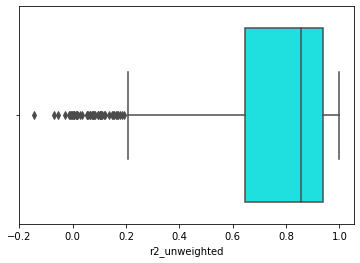

In [8]:
r2_boxplot = sns.boxplot(mv_lr_df["r2_unweighted"], color = "cyan")

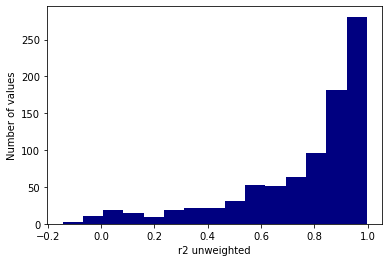

In [9]:
histogram = plt.hist(mv_lr_df["r2_unweighted"], bins = 15, color = "navy")

plt.xlabel("r2 unweighted")
plt.ylabel('Number of values')

plt.show()

In [10]:
convert_to_mouse = analysis_orthologues.set_index("mouse")
convert_to_mouse

,pig,rabbit,rat
mouse,,,
ENSMUSG00000000253,ENSSSCG00000001064,ENSOCUG00000017722,ENSRNOG00000017250
ENSMUSG00000000275,ENSSSCG00000029475,ENSOCUG00000011338,ENSRNOG00000002341
ENSMUSG00000000805,ENSSSCG00000023186,ENSOCUG00000009399,ENSRNOG00000002916
ENSMUSG00000000838,ENSSSCG00000012727,ENSOCUG00000014621,ENSRNOG00000057464
ENSMUSG00000000982,ENSSSCG00000017700,ENSOCUG00000000771,ENSRNOG00000011205
...,...,...,...
ENSMUSG00000071654,ENSSSCG00000024995,ENSOCUG00000017252,ENSRNOG00000045561
ENSMUSG00000072872,ENSSSCG00000025053,ENSOCUG00000011730,ENSRNOG00000005353
ENSMUSG00000074622,ENSSSCG00000030898,ENSOCUG00000021619,ENSRNOG00000016037


In [11]:
mouse_IDs = []

for gene in mv_lr_df.index:
    
    if gene in convert_to_mouse.index:
        mouse_IDs.append(gene)
        
    if gene in convert_to_mouse.rat.values:
            rat_to_mouse = convert_to_mouse[convert_to_mouse["rat"]== gene].index.values
            mouse_IDs.append(rat_to_mouse[0])
            
    if gene in convert_to_mouse.pig.values:
            pig_to_mouse = convert_to_mouse[convert_to_mouse["pig"]== gene].index.values
            mouse_IDs.append(pig_to_mouse[0])
            
    if gene in convert_to_mouse.rabbit.values:
            rabbit_to_mouse = convert_to_mouse[convert_to_mouse["rabbit"]== gene].index.values
            mouse_IDs.append(rabbit_to_mouse[0])

In [12]:
mv_lr_df ["mouse_ID"] = mouse_IDs
mv_lr_df

,intercept,slope,intercept_error,slope_error,intercept_pval,slope_pval,r2_unweighted,r2_weighted,mouse_ID
gene,,,,,,,,,
ENSMUSG00000000253,-0.000367,1.342178,0.004529,0.160848,0.935409,7.159660e-17,0.762380,0.835430,ENSMUSG00000000253
ENSMUSG00000000275,-1.894374,2.962519,0.420862,0.167625,0.000007,6.711401e-70,0.862253,0.896716,ENSMUSG00000000275
ENSMUSG00000000805,-0.014253,4.619336,0.010320,0.173514,0.167234,3.743987e-156,0.807111,0.899006,ENSMUSG00000000805
ENSMUSG00000000838,-0.188951,2.215212,0.080320,0.326673,0.018649,1.192446e-11,0.699570,0.650708,ENSMUSG00000000838
ENSMUSG00000000982,-48.955513,33.856494,25.556394,0.615989,0.055418,0.000000e+00,0.894557,0.977080,ENSMUSG00000000982
...,...,...,...,...,...,...,...,...,...
ENSSSCG00000030183,0.177364,0.746949,0.119694,0.269377,0.138388,5.556310e-03,0.439167,0.475516,ENSMUSG00000020946
ENSSSCG00000030211,-0.056451,1.372712,0.013348,0.036975,0.000023,1.074712e-301,0.974145,0.987477,ENSMUSG00000017119
ENSSSCG00000030377,-0.042643,2.110105,0.088477,0.109454,0.629832,8.132755e-83,0.954266,0.976829,ENSMUSG00000044701


In [13]:
mv_lr_df_sorted = mv_lr_df.sort_values(by = "mouse_ID")
mv_lr_df_sorted

,intercept,slope,intercept_error,slope_error,intercept_pval,slope_pval,r2_unweighted,r2_weighted,mouse_ID
gene,,,,,,,,,
ENSMUSG00000000253,-0.000367,1.342178,0.004529,0.160848,9.354085e-01,7.159660e-17,0.762380,0.835430,ENSMUSG00000000253
ENSOCUG00000017722,0.003966,0.997366,0.002690,0.063941,1.403705e-01,7.480774e-55,0.971623,0.971775,ENSMUSG00000000253
ENSRNOG00000017250,-0.024707,1.465687,0.020933,0.076001,2.378841e-01,7.158861e-83,0.614812,0.926474,ENSMUSG00000000253
ENSSSCG00000001064,-0.071988,1.648244,0.022244,0.053422,1.211259e-03,5.035384e-209,0.972838,0.985404,ENSMUSG00000000253
ENSOCUG00000011338,0.015578,0.747997,0.007231,0.126128,3.122643e-02,3.021279e-09,0.778615,0.778615,ENSMUSG00000000275
...,...,...,...,...,...,...,...,...,...
ENSMUSG00000074794,-0.019582,2.364267,0.004438,0.046652,1.020108e-05,0.000000e+00,0.925591,0.986980,ENSMUSG00000074794
ENSOCUG00000003569,0.025897,1.179964,0.022872,0.111700,2.575267e-01,4.390550e-26,0.754053,0.904406,ENSMUSG00000093930
ENSSSCG00000016872,-0.335538,2.437605,0.053600,0.087718,3.849317e-10,5.852576e-170,0.966216,0.986473,ENSMUSG00000093930


In [14]:
all_genes_list = []
genes_with_correct_fit = []
n_row = 0

for mouse_id in mv_lr_df_sorted.mouse_ID:
    
    if mouse_id not in all_genes_list:
        all_genes_list.append(mouse_id)
        r2_values = mv_lr_df_sorted.iloc[n_row:n_row+4, 6].values
        
        r2_number=0
        for r2 in r2_values:
            if r2 >= 0.6:
                r2_number +=1
        
        if r2_number >=3:
            genes_with_correct_fit.append(mouse_id)
    
        n_row +=4

print(len(genes_with_correct_fit))

169


In [20]:
all_genes_list = []
genes_with_correct_fit = []
n_row = 0

zero_good_r2 = 0
one_good_r2 = 0
two_good_r2 = 0
three_good_r2 = 0
four_good_r2 = 0
zero_genes = []

r2_sums = []

for mouse_id in mv_lr_df_sorted.mouse_ID:
    
    if mouse_id not in all_genes_list:
        all_genes_list.append(mouse_id)
        r2_values = mv_lr_df_sorted.iloc[n_row:n_row+4, 6].values
        r2_sum = sum(r2_values)
        r2_sums.append(r2_sum)
        r2_number=0
        for r2 in r2_values:
            if r2 >= 0.6:
                r2_number +=1
                
        if r2_number == 0:
            zero_genes.append(mouse_id)
            zero_good_r2 +=1
        
        if r2_number == 1:
            one_good_r2 +=1
            
        if r2_number == 2:
            two_good_r2 +=1
            
        if r2_number == 3:
            three_good_r2 +=1
            genes_with_correct_fit.append(mouse_id)
        
        if r2_number == 4:
            four_good_r2 +=1
            genes_with_correct_fit.append(mouse_id)
        
    
        n_row +=4

r2_max_index = r2_sums.index(max(r2_sums))
        

print("Number of genes with no good fits:", zero_good_r2)
print("Number of genes with one good fit:", one_good_r2)
print("Number of genes with two good fits:", two_good_r2)
print("Number of genes with three good fits:", three_good_r2)
print("Number of genes with four good fits:", four_good_r2)

print(zero_genes)

Number of genes with no good fits: 2
Number of genes with one good fit: 18
Number of genes with two good fits: 29
Number of genes with three good fits: 67
Number of genes with four good fits: 102
['ENSMUSG00000017428', 'ENSMUSG00000025873']


In [21]:
mv_lr_df_final = mv_lr_df.loc[mv_lr_df.mouse_ID.isin(genes_with_correct_fit)].copy()
mv_lr_df_final

,intercept,slope,intercept_error,slope_error,intercept_pval,slope_pval,r2_unweighted,r2_weighted,mouse_ID
gene,,,,,,,,,
ENSMUSG00000000253,-0.000367,1.342178,0.004529,0.160848,0.935409,7.159660e-17,0.762380,0.835430,ENSMUSG00000000253
ENSMUSG00000000275,-1.894374,2.962519,0.420862,0.167625,0.000007,6.711401e-70,0.862253,0.896716,ENSMUSG00000000275
ENSMUSG00000000805,-0.014253,4.619336,0.010320,0.173514,0.167234,3.743987e-156,0.807111,0.899006,ENSMUSG00000000805
ENSMUSG00000000838,-0.188951,2.215212,0.080320,0.326673,0.018649,1.192446e-11,0.699570,0.650708,ENSMUSG00000000838
ENSMUSG00000000982,-48.955513,33.856494,25.556394,0.615989,0.055418,0.000000e+00,0.894557,0.977080,ENSMUSG00000000982
...,...,...,...,...,...,...,...,...,...
ENSSSCG00000029507,-0.134119,1.838148,0.075480,0.159858,0.075586,1.339967e-30,0.889961,0.925417,ENSMUSG00000029333
ENSSSCG00000029652,-2.435039,2.268995,2.023701,0.341453,0.228876,3.029838e-11,0.856113,0.877238,ENSMUSG00000023010
ENSSSCG00000030211,-0.056451,1.372712,0.013348,0.036975,0.000023,1.074712e-301,0.974145,0.987477,ENSMUSG00000017119


In [22]:
good_fit_orthologues = analysis_orthologues.loc[analysis_orthologues.mouse.isin(genes_with_correct_fit)].copy()
good_fit_orthologues

,mouse,pig,rabbit,rat
8,ENSMUSG00000000253,ENSSSCG00000001064,ENSOCUG00000017722,ENSRNOG00000017250
9,ENSMUSG00000000275,ENSSSCG00000029475,ENSOCUG00000011338,ENSRNOG00000002341
24,ENSMUSG00000000805,ENSSSCG00000023186,ENSOCUG00000009399,ENSRNOG00000002916
25,ENSMUSG00000000838,ENSSSCG00000012727,ENSOCUG00000014621,ENSRNOG00000057464
29,ENSMUSG00000000982,ENSSSCG00000017700,ENSOCUG00000000771,ENSRNOG00000011205
...,...,...,...,...
2279,ENSMUSG00000071654,ENSSSCG00000024995,ENSOCUG00000017252,ENSRNOG00000045561
2286,ENSMUSG00000072872,ENSSSCG00000025053,ENSOCUG00000011730,ENSRNOG00000005353
2297,ENSMUSG00000074622,ENSSSCG00000030898,ENSOCUG00000021619,ENSRNOG00000016037
2301,ENSMUSG00000074794,ENSSSCG00000014156,ENSOCUG00000004378,ENSRNOG00000045649


In [27]:
condition_columns = ["replicate", "treatment", "time_point"]
index_columns = ["gene"] + condition_columns
count_type = "median"

def create_condition_info_good_fit_genes(species):
    counts_adata = hagai_2018.load_counts(species, scaling=count_type)
    species_gene_ids = good_fit_orthologues[species].tolist()
    counts_adata = counts_adata[counts_adata.obs.time_point.isin(["0", "2", "4", "6"]), species_gene_ids].copy()
    info_df = hagai_2018.calculate_counts_condition_stats(counts_adata)
    info_df.insert(1, "species", species)
    info_df = info_df.merge(
        data.load_and_recalculate_txburst_results(species, condition_columns=condition_columns, count_type=count_type),
        on=index_columns,
        how="left",
    )
    return info_df


good_fit_condition_info_df = pd.concat([create_condition_info_good_fit_genes(species) for species in species_to_compare])
good_fit_condition_info_df

,gene,species,replicate,treatment,time_point,n_barcodes,min,max,mean,variance,std_dev,skew,k_on,k_off,k_syn,bf_point,bs_point
0,ENSMUSG00000000253,mouse,1,unst,0,2126,0.0,3.561820,0.038111,0.060869,0.246716,7.766711,0.024800,0.717060,1.139708,0.023971,1.589418
1,ENSMUSG00000000253,mouse,1,lps,2,2537,0.0,2.741993,0.025488,0.033200,0.182209,8.270841,NaN,NaN,NaN,NaN,NaN
2,ENSMUSG00000000253,mouse,1,pic,2,3025,0.0,4.791318,0.031598,0.069161,0.262985,10.811880,0.006008,0.279240,1.475049,0.005882,5.282365
3,ENSMUSG00000000253,mouse,1,lps,4,2366,0.0,2.399424,0.011571,0.016140,0.127043,12.678754,NaN,NaN,NaN,NaN,NaN
4,ENSMUSG00000000253,mouse,1,pic,4,2394,0.0,4.400096,0.017332,0.038341,0.195808,14.479786,0.005669,0.688503,2.149932,0.005623,3.122617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3544,ENSRNOG00000061595,rat,3,pic,2,2965,0.0,4.155890,0.093080,0.129696,0.360133,4.456944,NaN,NaN,NaN,NaN,NaN
3545,ENSRNOG00000061595,rat,3,lps,4,1210,0.0,3.800972,0.228081,0.231387,0.481027,2.954341,NaN,NaN,NaN,NaN,NaN
3546,ENSRNOG00000061595,rat,3,pic,4,1870,0.0,3.693897,0.113028,0.165191,0.406437,4.151991,NaN,NaN,NaN,NaN,NaN
3547,ENSRNOG00000061595,rat,3,lps,6,2635,0.0,4.216097,0.078678,0.105967,0.325526,5.449983,NaN,NaN,NaN,NaN,NaN


In [28]:
if results_output_path is not None:
    save_all_species_data(Path(results_output_path))

In [31]:
mv_plot_output = widgets.Output()
mv_info_output = widgets.Output()


@widgets.interact(mouse_gene_id=ui.make_gene_selector(gene_info_df.loc[analysis_orthologues.mouse].symbol, rows=5))
def plot_mv(mouse_gene_id):
    gene_ids = analysis_orthologues.loc[analysis_orthologues.mouse == mouse_gene_id].squeeze().to_list()
    stats_subset = condition_info_df.loc[condition_info_df.gene.isin(gene_ids)]
    lr_subset = mv_lr_df.loc[gene_ids].copy()
    lr_subset.insert(0, "symbol", gene_info_df.symbol[lr_subset.index])

    plot_df = stats_subset[["gene", "species", "replicate", "treatment", "time_point", "mean", "variance", "bs_point", "bf_point"]].copy()
    plot_df = plot_df.merge(lr_subset, on="gene").sort_values(by=["gene", "mean"])
    plot_df["lr_y"] = (plot_df["mean"] * plot_df["slope"]) + plot_df["intercept"]

    
    colours = sns.color_palette()[:len(gene_ids)]
    
    mv_plot_output.clear_output()
    with mv_plot_output:
        sns.scatterplot(
            plot_df["mean"],
            plot_df["variance"],
            style=plot_df["treatment"],
            style_order=["unst", "lps", "pic"],
            hue=plot_df["species"],
            hue_order=species_to_compare,
            palette=colours,
        )

        ax = sns.lineplot(
            plot_df["mean"],
            plot_df["lr_y"],
            hue=plot_df["species"],
            hue_order=species_to_compare,
            palette=colours,
            legend=None,
        )
        for line in ax.lines:
            line.set_linestyle("--")

        ui.zero_axes_origin()
        plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
        plt.xlabel("Mean")
        plt.ylabel("Variance")
        plt.show()

    mv_info_output.clear_output()
    with mv_info_output:
        display(lr_subset)

display(widgets.HBox((mv_plot_output, mv_info_output)))

interactive(children=(Select(description='mouse_gene_id', options=(('A230050P20Rik', 'ENSMUSG00000038884'), ('…